# Baseline analysis for predicting next day's Covid-19 cases from prior 30

In [1]:
import os
import importlib

import cuml
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


import dsci592.model as model

/home/noah/miniconda3/envs/rapids-22.02/lib/python3.9/site-packages/cupy/_environment.py:434: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda115

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [3]:
importlib.reload(model)

<module 'dsci592.model' from '/home/noah/miniconda3/envs/rapids-22.02/lib/python3.9/site-packages/dsci592/model.py'>

In [4]:
pd.set_option("display.max_columns", None)
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [4]:
!python --version

Python 3.9.10


In [5]:
golden_dataset_file_name = os.path.join('/', 'data', 'projects', 'drexel', 'dsci592', 'feeFiFoFum.pkl')
with tf.device('/gpu:0'):  # using other GPU for another task
    df = model.load_dataset(golden_dataset_file_name)

# train_ds, val_ds, test_ds = model.get_train_test_eval_ds()


2022-02-21 08:25:46.557591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 08:25:46.557870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 08:25:46.558311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 08:25:46.558517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 08:25:46.558716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

AttributeError: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/home/noah/miniconda3/envs/rapids-22.02/lib/python3.9/site-packages/pandas/_libs/internals.cpython-39-x86_64-linux-gnu.so'>

In [8]:
def get_new_loop():
    train_ds, val_ds, test_ds = model.get_train_test_eval_ds()
    return ('train', train_ds), ('validate', val_ds), ('test', test_ds)
    

## Baseline 1: Guess zero every time

In [20]:
for name, ds in get_new_loop():
    sum = count = 0
    for _, y in ds:
        y_ = y.numpy().flatten()
        sum += y_.sum()
        count += y_.shape[0]
    print(f'{name}: {sum/count}')


train: 1738.2500355774011
validate: 1754.9772079984493
test: 1739.3318410911274


## Baseline 2: Guess the 30th date every time

In [51]:
for name, ds in get_new_loop():
    errors = count = 0
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,-1:,:1].flatten()
        errors += np.sum(np.abs(y_ - x_))
        count += y_.shape[0]
    print(f'{name}: {errors/count}')


train: 9.785121290955985
validate: 9.549475865976769
test: 9.840210704599464


## Baseline 3: Guess the mean of the 30 days every time

In [63]:
for name, ds in get_new_loop():
    errors = count = 0
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,:,:1]
        x_ = np.mean(x_, axis=1).flatten()
        errors += np.sum(np.abs(y_ - x_))
        count += y_.shape[0]
    print(f'{name}: {errors/count}')


train: 121.31485035080716
validate: 120.17304839525893
test: 120.88257879796626


## Baseline 4: Linear regression

In [116]:
for name, ds in get_new_loop():
    errors = count = 0
    lr = LinearRegression()
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,:,:1]
        days = x_.shape[1]
        z = np.arange(days).reshape(-1,1)
        next_date = np.array([days + 1]).reshape(-1,1)
        for i in range(x_.shape[0]):
            lr.fit(z,x_[i])
            errors += np.abs(y[i] - lr.predict(next_date)[0][0])
            count += 1
    print(f'{name}: {errors[0][0]/count}')


train: [[36.93661786]]
validate: [[36.07154467]]
test: [[36.6260068]]


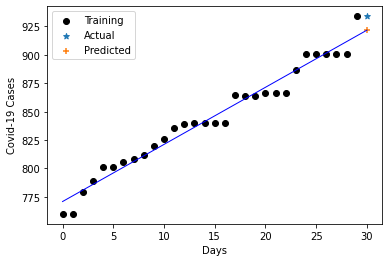

In [142]:
z = np.arange(days).reshape(-1,1)
plt.scatter(z, x_[i], color="black", label='Training')
z_ = np.arange(days+1).reshape(-1,1)
plt.plot(z_, lr.predict(z_), color="blue", linewidth=1)
plt.scatter(30, y_[i], marker='*', label='Actual')
plt.scatter(30, lr.predict(z_)[-1], marker='+', label='Predicted')
plt.ylabel('Covid-19 Cases')
plt.xlabel('Days')
plt.legend()
# plt.xticks(())
# plt.yticks(())
plt.savefig('linear_regression_example.png')
_ = plt.show()


# Baseline analysis for predicting next seven day's Covid-19 cases from prior 30

In [5]:
# train_ds, val_ds, test_ds = model.get_train_test_eval_ds(train='./data/train7/x_*.npy', test='./data/test7/x_*.npy', eval_='./data/eval7/x_*.npy', days_to_predict=7)

DAYS_TO_PREDICT=7

def get_new_loop():
    train_ds, val_ds, test_ds = model.get_train_test_eval_ds(train='./data/train7/x_*.npy', test='./data/test7/x_*.npy', eval_='./data/eval7/x_*.npy', days_to_predict=DAYS_TO_PREDICT)
    return ('train', train_ds), ('validate', val_ds), ('test', test_ds)

## Baseline 1: Guess zero every time

In [190]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for _, y in ds:
        count += y_.shape[0]
        y_ = y.numpy().squeeze()
        x_  = np.ones(y_.shape)
        errors += np.sum(np.abs(y_ - x_), axis=0)
    for i in range(DAYS_TO_PREDICT):
        print(f'{name} mae for day {i}: {errors[i]/count}')

train mae for day 0: 1756.0914379124538
validate mae for day 0: 1802.5589782118707
test mae for day 0: 1719.388321305421


In [188]:
# OLD VERSION -- SLOW!!!!
for name, ds in get_new_loop():
    sums = [0] * DAYS_TO_PREDICT
    counts = [0] * DAYS_TO_PREDICT
    for _, ys in ds:
        for y_days in ys:
            for i, y in enumerate(y_days):
                sums[i] += y
                counts[i] += 1
    for i in range(DAYS_TO_PREDICT):
        print(f'{name} mae for day {i}: {sums[i]/counts[i]}')


train mae for day 0: [1756.4777]
validate mae for day 0: [1798.8082]
test mae for day 0: [1720.9961]


## Baseline 2: Guess the 30th date every time

In [234]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for x, y in ds:
        count += x_.shape[0]
        y_ = y.numpy().squeeze(-1)
        x_ = x.numpy()[:,-1:,:1]
        x_ = x_.reshape(-1,1)
        x_ = np.repeat(x_, DAYS_TO_PREDICT, axis=1)
        errors += np.sum(np.abs(y_ - x_), axis=0)
    for i in range(DAYS_TO_PREDICT):
        print(f'{name} mae for day {i}: {errors[i]/count}')


train mae for day 0: 8.429402354856396
train mae for day 1: 16.990242066834252
train mae for day 2: 25.797032729128528
train mae for day 3: 34.780839760428364
train mae for day 4: 43.895477709938085
train mae for day 5: 53.218530382912476
train mae for day 6: 62.822478938158575
validate mae for day 0: 8.351147170865598
validate mae for day 1: 16.78191860882172
validate mae for day 2: 25.43629492315069
validate mae for day 3: 34.28488045033583
validate mae for day 4: 43.40373543147745
validate mae for day 5: 52.70864842620314
validate mae for day 6: 62.26579176876116
test mae for day 0: 8.361327278551375
test mae for day 1: 16.819735825592133
test mae for day 2: 25.49928963087185
test mae for day 3: 34.34123721052929
test mae for day 4: 43.431795142356464
test mae for day 5: 52.75118237832338
test mae for day 6: 62.35643571818884


## Baseline 3: Guess the mean of the 30 days every time

In [24]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for x, y in ds:
        y_ = y.numpy().squeeze()
        x_ = x.numpy()[:,:,:1]
        x_ = np.mean(x_, axis=1).flatten()
        x_ = x_.reshape(-1,1)
        x_ = x_ = np.repeat(x_, DAYS_TO_PREDICT, axis=1)
        count += y_.shape[0]
        errors += np.sum(np.abs(y_ - x_), axis=0)
    for i in range(DAYS_TO_PREDICT):
        print(f'{name} mae for day {i}: {errors[i]/count}')


train mae for day 0: 113.34337381354005
train mae for day 1: 121.7092398237874
train mae for day 2: 130.24927769751142
train mae for day 3: 138.94539164550145
train mae for day 4: 147.739523060998
train mae for day 5: 156.70327931526907
train mae for day 6: 165.89514317538908
validate mae for day 0: 112.74494491526222
validate mae for day 1: 120.98651404511313
validate mae for day 2: 129.3879898049562
validate mae for day 3: 137.9555395041173
validate mae for day 4: 146.73057175283276
validate mae for day 5: 155.6588614749629
validate mae for day 6: 164.78974649766826
test mae for day 0: 112.0805320146442
test mae for day 1: 120.35551247426044
test mae for day 2: 128.78724676464043
test mae for day 3: 137.3621345783237
test mae for day 4: 146.1271622000351
test mae for day 5: 155.0805315432236
test mae for day 6: 164.2627304775302


## Baseline 4: Linear regression

In [7]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    count = 0
    lr = LinearRegression()
    for x, y in ds:
        y_ = y.numpy().squeeze()  
        # print(y_.shape)
        # abort
        x_ = x.numpy()[:,:,:1]
        days = x_.shape[1]
        z = np.arange(days).reshape(-1,1)
        # next_date = np.array([days + 1]).reshape(-1,1)
        next_dates = np.arange(days +1, days + 1 + DAYS_TO_PREDICT)
        for i in range(x_.shape[0]):
            lr.fit(z,x_[i])
            for j in range(DAYS_TO_PREDICT):
                errors[j] += np.abs(y[i][j] - lr.predict(next_dates[j].reshape(-1,1))[0][0])
        count += y_.shape[0]
    for k in range(DAYS_TO_PREDICT):
        print(f'{name} mae for day {k}: {errors[k]/count}')


train mae for day 0: 31.09305731357317
train mae for day 1: 36.561657346368555
train mae for day 2: 42.30315053809475
train mae for day 3: 48.37364123300961
train mae for day 4: 54.7286052509776
train mae for day 5: 61.37189079944005
train mae for day 6: 68.4145175322037
validate mae for day 0: 31.24242652543075
validate mae for day 1: 36.6673698326716
validate mae for day 2: 42.37596151672907
validate mae for day 3: 48.39688698364386
validate mae for day 4: 54.81291012785065
validate mae for day 5: 61.55768346982288
validate mae for day 6: 68.65197049716348
test mae for day 0: 31.021310096697793
test mae for day 1: 36.46308211015402
test mae for day 2: 42.17483292854018
test mae for day 3: 48.15547451311681
test mae for day 4: 54.50655840335501
test mae for day 5: 61.22295177178717
test mae for day 6: 68.31251791398272


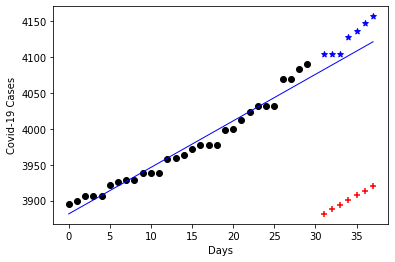

In [15]:
z = np.arange(days).reshape(-1,1)
plt.scatter(z, x_[i], color="black", label='Training')
z_ = np.arange(days+1+DAYS_TO_PREDICT).reshape(-1,1)
plt.plot(z_, lr.predict(z_), color="blue", linewidth=1)
for j in range(DAYS_TO_PREDICT):
    plt.scatter(31+j, y_[i][j], marker='*', label='Actual', color='blue')
    plt.scatter(31 + j, lr.predict(z_)[j], marker='+', label='Predicted', color='red')
plt.ylabel('Covid-19 Cases')
plt.xlabel('Days')
# plt.legend()
# plt.xticks(())
# plt.yticks(())
plt.savefig('linear_regression_example.png')
_ = plt.show()

In [14]:
i

596

In [16]:
x_.shape
x_ = np.mean(x_, axis=1).flatten()
x_ = x_.reshape(-1,1)
x_ = x_ = np.repeat(x_, DAYS_TO_PREDICT, axis=1)
x_.shape

(995, 7)

In [ ]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for x, y in ds:
        print(x.shape, y.shape)
        print(x[0][-1][0])
        print(y[0][0][0])
        return
        print('breaking')
        break
        
        

In [185]:
train mae for day 0: 9.840150955581118
validate mae for day 0: 9.792210488958693
test mae for day 0: 9.854986715908877

array([1759., 1759., 1759., 1759., 1759., 1759., 1759.], dtype=float32)

In [184]:
y_[0]

array([1759., 1848., 1848., 1873., 1873., 1873., 1972.], dtype=float32)

In [179]:
x_

array([[1759., 1759., 1759., ..., 1759., 1759., 1759.],
       [1131., 1131., 1131., ..., 1131., 1131., 1131.],
       [1733., 1733., 1733., ..., 1733., 1733., 1733.],
       ...,
       [ 961.,  961.,  961., ...,  961.,  961.,  961.],
       [ 515.,  515.,  515., ...,  515.,  515.,  515.],
       [1282., 1282., 1282., ..., 1282., 1282., 1282.]], dtype=float32)

In [112]:
x = x_[0]
z = np.arange(x.shape[0]).reshape(-1,1)
y = y_[0]
# z = np.expand_dims(z,1)
lr = LinearRegression()
lr.fit(z,x)
np.abs(y - lr.predict(np.array([31]).reshape(-1,1))[0][0])

6.5670003707823525

In [104]:
z

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29]])

In [91]:
z = np.arange(x.shape[0])
z = np.expand_dims(z,1)
print(z.shape)
x = np.concatenate((z, x), axis=1)

(30, 1)


array([[  0., 488.],
       [  1., 491.],
       [  2., 492.],
       [  3., 498.],
       [  4., 500.],
       [  5., 515.],
       [  6., 530.],
       [  7., 530.],
       [  8., 531.],
       [  9., 532.],
       [ 10., 538.],
       [ 11., 548.],
       [ 12., 553.],
       [ 13., 569.],
       [ 14., 578.],
       [ 15., 579.],
       [ 16., 579.],
       [ 17., 582.],
       [ 18., 591.],
       [ 19., 595.],
       [ 20., 606.],
       [ 21., 633.],
       [ 22., 638.],
       [ 23., 640.],
       [ 24., 651.],
       [ 25., 662.],
       [ 26., 672.],
       [ 27., 687.],
       [ 28., 687.],
       [ 29., 692.]])

In [95]:
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)

reg.coef_

reg.intercept_

reg.predict(np.array([[3, 5]]))

array([16.])

In [97]:
y.shape

(4,)